In [1]:
import networkx as nx
import ndlib.models.epidemics as ep
import ndlib.models.ModelConfig as mc
import ndlib.models.CompositeModel as gc
from ndlib.viz.mpl.DiffusionTrend import DiffusionTrend
from ndlib.viz.mpl.DiffusionPrevalence import DiffusionPrevalence
from pymongo import MongoClient
import numpy as np
from ndlibCustom.SEIR_ASModel import SEIR_ASModel
from statsmodels.distributions.empirical_distribution import ECDF
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd

#Method 5 - Read Pickle into NX (
#Currently takes around 7.5GB of memory
G = nx.read_gpickle('Datasets/dataset.gpickle')
relabeled = nx.convert_node_labels_to_integers(G)
del(G)
print(len(relabeled.nodes()))
print(len(relabeled.edges()))

1229994
9032197


  0%|          | 0/60 [00:00<?, ?it/s]

Simulating...


100%|██████████| 60/60 [05:13<00:00,  5.22s/it]


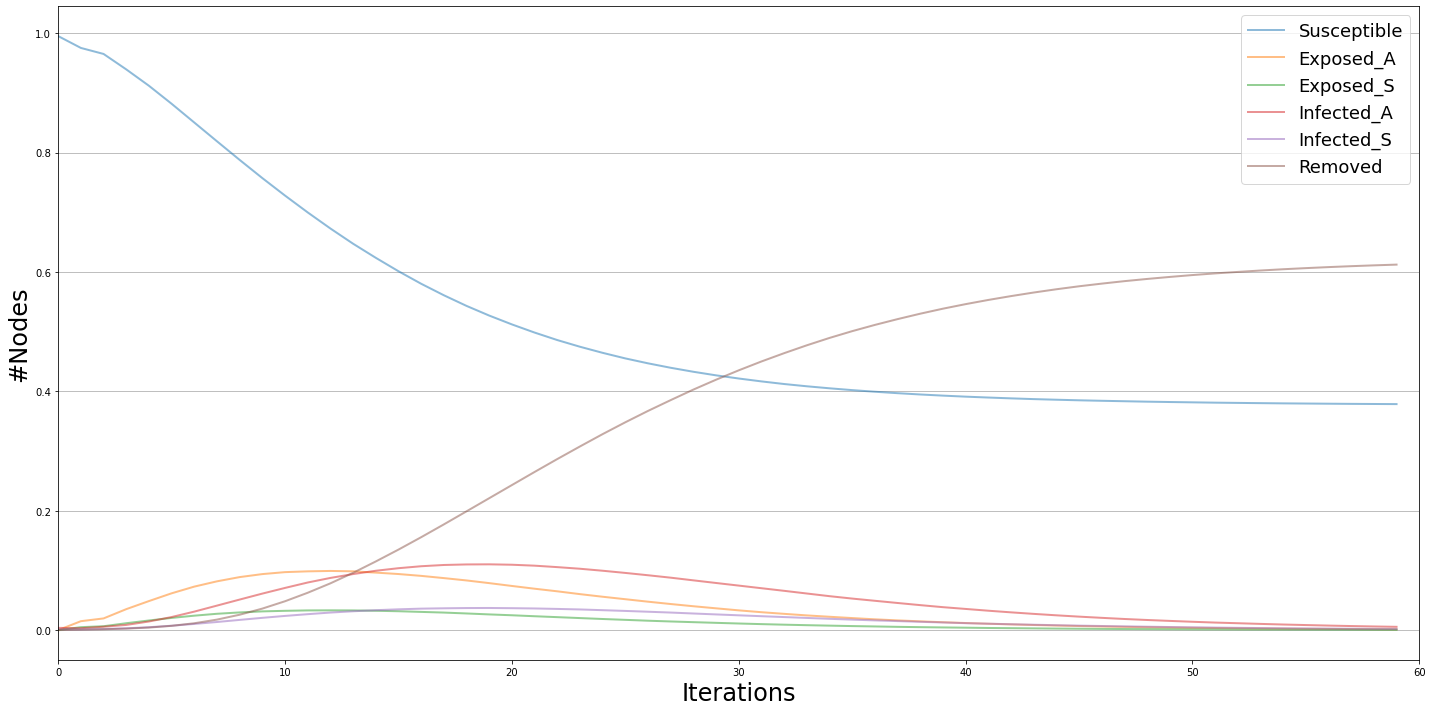

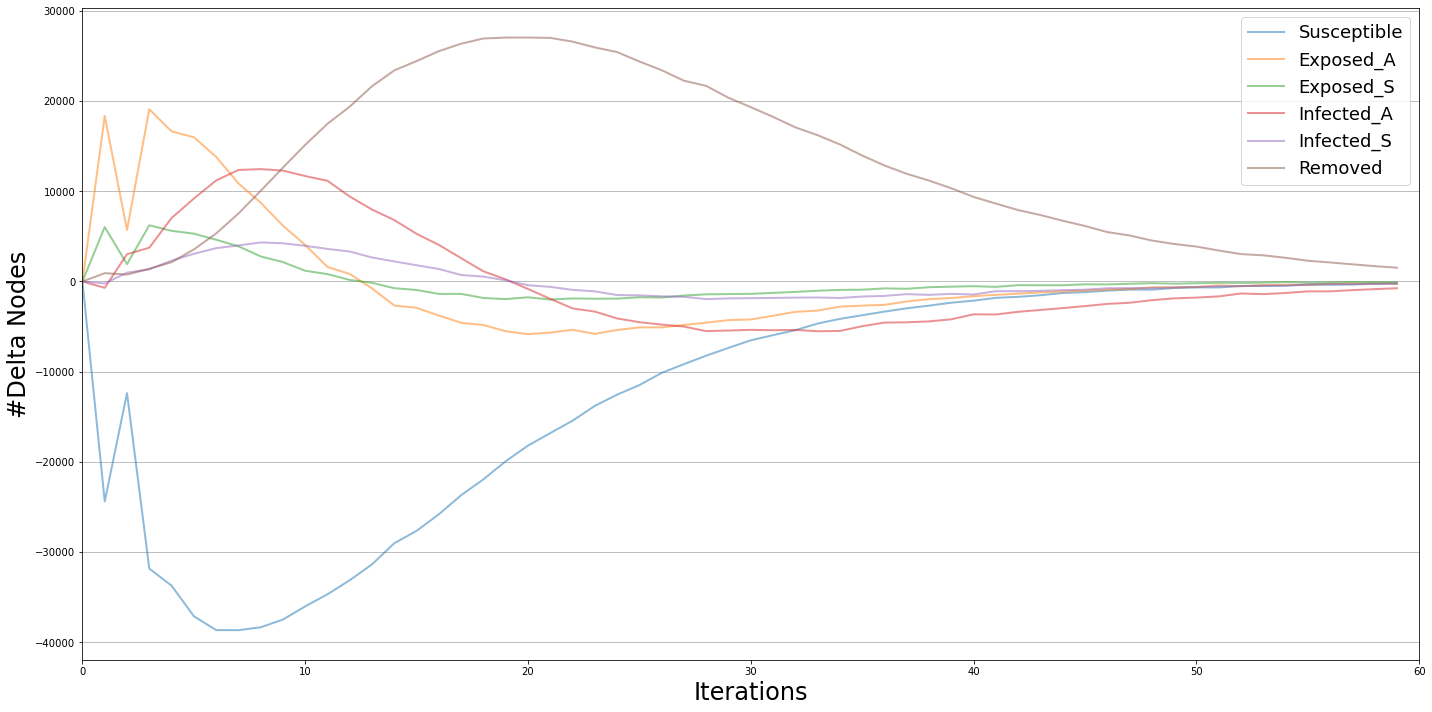

In [2]:
#CUSTOM SEIR_AS MODEL SIMULATION
print("Simulating...")
# Model selection
model = SEIR_ASModel(relabeled)

# Model Configuration
cfg = mc.Configuration()
cfg.add_model_parameter('beta', 0.57) #Infection rate from I_A/S Neighbors
cfg.add_model_parameter('gamma', 0.15) #Recovery/Removal rate
cfg.add_model_parameter('alpha', 0.2) #Latent period
cfg.add_model_parameter('kappa', 0.25) #Symptomatic/Asymptomatic Ratio

#This parameter "smoothens" out the infection rate in the first iterations.
#1: 1-(1-beta)^(num_of_infected_neighbors)[0.99 on > 5 infected neighbors]
#2: beta*(average_infected_weight)
cfg.add_model_parameter('tp_rate', 0) #Infection rate does not depend on neighbour sample size


cfg.add_model_parameter("fraction_infected", 0.005) #Starting infected nodes
model.set_initial_status(cfg)

# Simulation execution
#iteration = model.iteration()
iterations = model.iteration_bunch(60,progress_bar=True)
trends = model.build_trends(iterations)

viz = DiffusionTrend(model, trends)
p = viz.plot()

viz2 = DiffusionPrevalence(model, trends)
p2 = viz2.plot()

Text(0, 0.5, 'ECCDF')

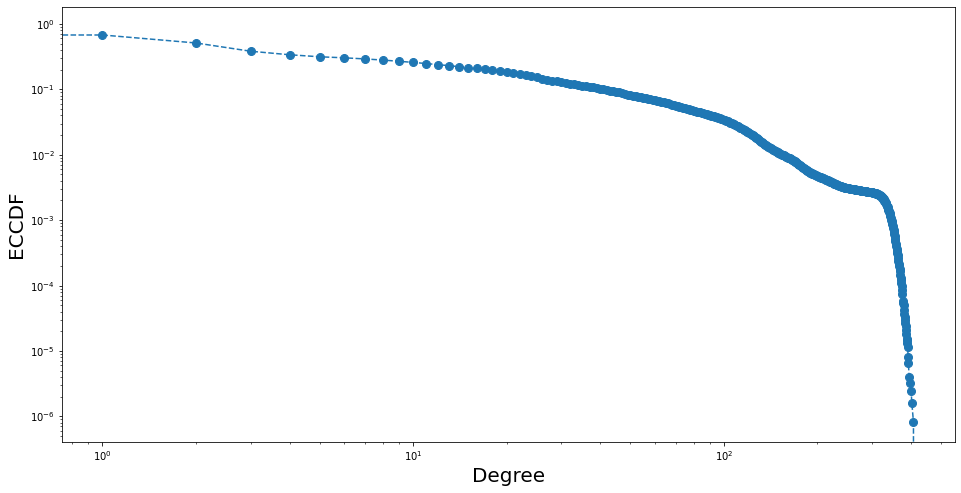

In [3]:
density = nx.density(relabeled)
degree = list(dict(relabeled.degree()).values())
#ECCDF in loglog scale
cdf = ECDF(degree)
x = np.unique(degree)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.loglog(x,1-y,marker='o',ms=8, linestyle='--')
axes.set_xlabel('Degree',size=20)
axes.set_ylabel('ECCDF', size=20)

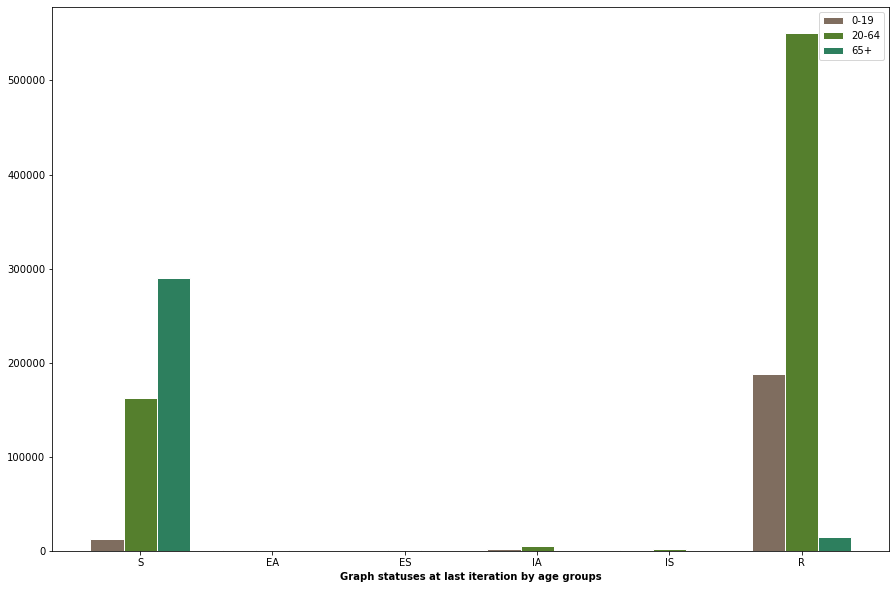

In [4]:
#Create complete status map by dymanically rebuilding infection iteration results
#Keys are nodes, values are final statuses
#Look for keys in graph to get attributes

graph_stat = {}
for i in relabeled.nodes():
    graph_stat[i] = 0
for iter in iterations:
    for s in iter['status']:
        graph_stat[s] = iter['status'][s]    

stats_giovani = {0:[],1:[],2:[],3:[],4:[],5:[]}
stats_attivi = {0:[],1:[],2:[],3:[],4:[],5:[]}
stats_anziani = {0:[],1:[],2:[],3:[],4:[],5:[]}
for i in graph_stat:
    if relabeled.nodes[i]['age'] == '65+':
        stats_anziani[graph_stat[i]].append(i)
    elif relabeled.nodes[i]['age'] == '20-64':
        stats_attivi[graph_stat[i]].append(i)
    else:
        stats_giovani[graph_stat[i]].append(i)
        
giovani_p = []
attivi_p = []
anziani_p = []
for i in stats_giovani:
    giovani_p.append(len(stats_giovani[i]))
    attivi_p.append(len(stats_attivi[i]))
    anziani_p.append(len(stats_anziani[i]))    

plt.rcParams['figure.figsize'] = [15, 10]
# set width of bar
barWidth = 0.25
 
# set height of bar
bars1 = [12, 30, 1, 8, 22]
bars2 = [28, 6, 16, 5, 10]
bars3 = [29, 3, 24, 25, 17]
 
# Set position of bar on X axis
r1 = np.arange(len(giovani_p))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, giovani_p, color='#7f6d5f', width=barWidth, edgecolor='white', label='0-19')
plt.bar(r2, attivi_p, color='#557f2d', width=barWidth, edgecolor='white', label='20-64')
plt.bar(r3, anziani_p, color='#2d7f5e', width=barWidth, edgecolor='white', label='65+')

# Add xticks on the middle of the group bars
plt.xlabel('Graph statuses at last iteration by age groups', fontweight='bold')
labels = ['S', 'EA', 'ES', 'IA', 'IS',"R"]
plt.xticks([r + barWidth for r in range(len(giovani_p))], labels)
 
# Create legend & Show graphic
plt.legend()
plt.show()

In [5]:
Gcc = sorted(nx.connected_components(relabeled), key=len, reverse=True)
G0 = relabeled.subgraph(Gcc[0])
G1 = relabeled.subgraph(Gcc[1])
print(len(G0))
print(len(G1))

781979
221


In [6]:
agedistrib_g1 = []
a1 = 0
a2 = 0
a3 = 0
for i in relabeled.nodes():
    if relabeled.nodes[i]['age'] == '65+':
        a3 += 1
    elif relabeled.nodes[i]['age'] == '20-64':
        a2 += 1
    else: 
        a1 +=1
print("Disribuzione di età su grafo totale")
print("Giovani:",a1,"Attivi:",a2,"Anziani:",a3)
print()
g1 = a1
g2 = a2
g3 = a3
for i in G0.nodes():
    if G0.nodes[i]['age'] == '65+':
        a3 -= 1
    elif G0.nodes[i]['age'] == '20-64':
        a2 -= 1
    else: 
        a1 -=1
print("Disribuzione di età fuori dalla Giant Component (in percentuale sul totale)")
print("Giovani:",a1,"(",round((a1/g1)*100,3),")","Attivi:",a2,"(",round((a2/g2)*100,3),")","Anziani:",a3,"(",round((a3/g3)*100,3),")")
print()
print("Nodi appartenenti alla Giant Component")
print("Giovani:",g1-a1,"Attivi:",g2-a2,"Anziani:",g3-a3)
print()
print("Nodi con status (R) all'ultima iterazione")
print("Giovani:",len(stats_giovani[5]),"Attivi:",len(stats_attivi[5]),"Anziani:",len(stats_anziani[5]))

Disribuzione di età su grafo totale
Giovani: 203686 Attivi: 720971 Anziani: 305337

Disribuzione di età fuori dalla Giant Component (in percentuale sul totale)
Giovani: 9012 ( 4.424 ) Attivi: 147077 ( 20.4 ) Anziani: 291926 ( 95.608 )

Nodi appartenenti alla Giant Component
Giovani: 194674 Attivi: 573894 Anziani: 13411

Nodi con status (R) all'ultima iterazione
Giovani: 187655 Attivi: 550332 Anziani: 15037


Mean percentual of workers for sez: 0.4955315110512873


Text(0, 0.5, 'ECDF')

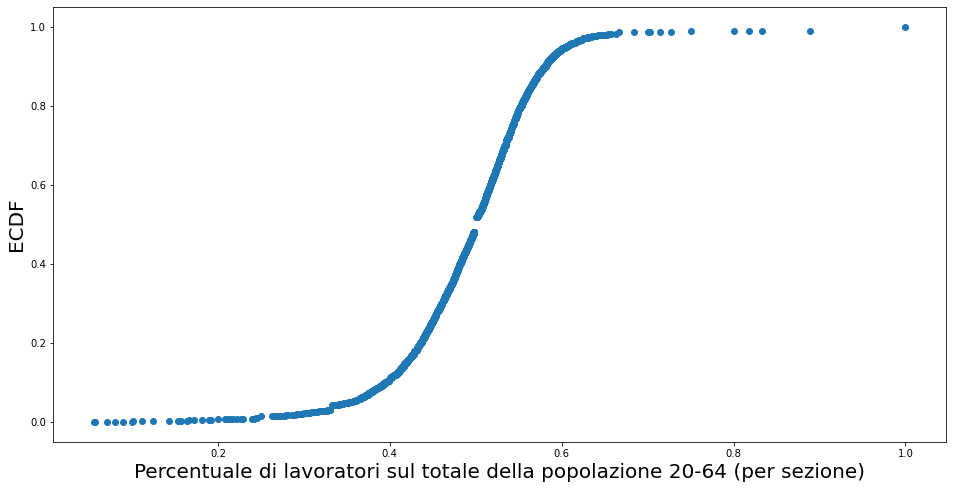

In [7]:
client = MongoClient('localhost', 27017)
db = client['tesi']
db_sezioni = db['sezioni']
db_lavoro = db['lavoro']

work_dist = []
for i in list(db_sezioni.find()):
    #print("Indexing sez:",i["properties"]["SEZ"], end="\r", flush=True)
    num_attivi = 0
    num_workers = 0
    if "famiglie" in i.keys():
        for fam in i["famiglie"]:
            for mem in fam["members"]:
                if mem["age"] == "20-64": 
                    num_attivi += 1
                    if "sez_lavoro" in mem.keys(): num_workers += 1
        if (num_workers != 0 and num_attivi != 0):
            work_dist.append({"sez":i["properties"]["SEZ"],"num":num_workers/num_attivi})

list_dist =  [i["num"] for i in work_dist]
print("Mean percentual of workers for sez:",np.mean(list_dist))

# ECDF linear scale
cdf = ECDF(list_dist)
x = np.unique(list_dist)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=6, linestyle='None')
axes.set_xlabel('Percentuale di lavoratori sul totale della popolazione 20-64 (per sezione)',size=20)
axes.set_ylabel('ECDF', size = 20)

In [8]:
#TODO: Check if herd immunity has ben achieved
G0_susceptible = []
for i in G0.nodes():
    if i in graph_stat.keys():
        if graph_stat[i] == 0:
            G0_susceptible.append(i)
print("Nodi in stato S all'ultima iterazione:",len(G0_susceptible))
print()

neighbors = {}
for i in G0_susceptible:
    neighborhood = [n for n in relabeled.neighbors(i)]
    for n in neighborhood:
        neighbors[n] = graph_stat[n]
print("Numero di neighbors dei nodi con stato S all'ultima iterazione:",len(neighbors))
print()

NS = 0
NIE = 0
NR = 0
for i in neighbors:
    if neighbors[i] == 0: NS += 1
    elif neighbors[i] == 5: NR += 1
    else: NIE +=1
        
print("S:",NS,"R:",NR,"EAS/IAS:",NIE)

Nodi in stato S all'ultima iterazione: 29348

Numero di neighbors dei nodi con stato S all'ultima iterazione: 41228

S: 20777 R: 19504 EAS/IAS: 947


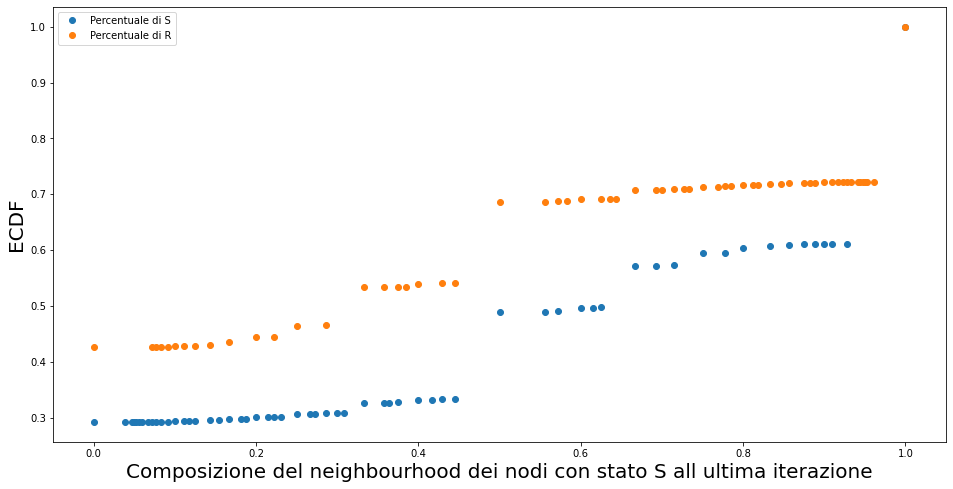

<Figure size 1152x576 with 0 Axes>

In [9]:
neighbors_s = {}
neighbors_r = {}
for i in G0_susceptible:
    neighborhood = [n for n in relabeled.neighbors(i)]
    neighbors_s[i] = []
    neighbors_r[i] = []
    sum = 0
    sus = 0
    rem = 0
    for n in neighborhood:
        sum += 1
        if graph_stat[n] == 0: sus += 1
        if graph_stat[n] == 5: rem += 1
    neighbors_s[i].append(sus/sum)
    neighbors_r[i].append(rem/sum)
    
neighbors_s = [n[0] for n in neighbors_s.values()]
neighbors_r = [n[0] for n in neighbors_r.values()]

# ECDF linear scale
cdf = ECDF(neighbors_s)
x = np.unique(neighbors_s)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes = fig_cdf.gca()
axes.plot(x,y,marker='o',ms=6, linestyle='None', label='Percentuale di S')
cdf = ECDF(neighbors_r)
x = np.unique(neighbors_r)
y = cdf(x)
fig_cdf = plt.figure(figsize=(16,8))
axes.plot(x,y,marker='o',ms=6, linestyle='None', label='Percentuale di R')
axes.set_xlabel('Composizione del neighbourhood dei nodi con stato S all ultima iterazione',size=20)
axes.set_ylabel('ECDF', size = 20)
axes.legend()
